In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------
# Simulation Parameters
# ---------------------
num_sellers = 2       # Number of sellers
num_buyers  = 5        # Number of buyers
num_days    = 50      # Number of days to simulate
num_interactions = 10_000 # Daily buyer-seller interactions
delta = 0.0075         # Step size for price change

# ----------------------------
# Initialize Sellers and Buyers
# ----------------------------
np.random.seed(43)  # For reproducibility

# Start each seller at an initial price, e.g., 10.
seller_prices = np.random.random(num_sellers) * 0 + 1.8
marginal_cost = np.random.uniform(0, 1, num_sellers) * 1

# Buyers: each has a linear demand function: Q_d = max(A - B * price, 0).
buyer_A = np.random.uniform(30, 50, num_buyers)         # Demand intercepts
buyer_B = np.random.uniform(4.8, 5.2, num_buyers)         # Demand slopes

def demand(price):
    if len(price.shape) >= 1:
        return np.maximum(buyer_A[:, None] - buyer_B[:, None] * price[None], 0)
    return np.maximum(buyer_A - buyer_B * price, 0)

def wtp(quantity, buyer_A, buyer_B):
    return buyer_A/buyer_B - quantity/buyer_B 


# For recording simulation statistics:
avg_prices = []
# Save prices of all sellers each day (each element is a copy of seller_prices at that day)
all_seller_prices = np.empty((num_days, num_sellers))
all_seller_profits = np.empty((num_days, num_sellers))

# ---------------------
# Simulation Loop
# ---------------------
for day in range(num_days):
    demand_at_p = demand(seller_prices)
    inventory = demand_at_p.sum(0) # How much is produced
    sales = np.zeros(num_sellers) # Quantity sold by each seller
    WTPs = wtp(demand_at_p, buyer_A[:, None], buyer_B[:, None]) # (B, S)
    buyer_buys = np.zeros(num_buyers)
    avg_demand = demand(seller_prices.mean())
    
    # --- Market Interactions ---
    # For each interaction, choose a buyer at random.
    for interaction in range(num_interactions):
        buyer_idx = interaction % num_buyers
        if buyer_buys[buyer_idx] >= avg_demand[buyer_idx]:
            continue
        # buyer_idx = np.random.randint(0, num_buyers)
        # while buyer_buys[buyer_idx] >= avg_demand[buyer_idx]:
        #     buyer_idx = np.random.randint(0, num_buyers)

        # Identify sellers with available inventory.
        available = np.where(inventory > 1)[0]
        if available.size == 0:
            break  # No supply available.
        
        # Filter sellers where the buyer's willingness-to-pay is positive:
        candidate_mask = WTPs[buyer_idx, available] >= (seller_prices[available]-1e-9)
        candidates = available[candidate_mask]

        if candidates.size == 0:
            continue  # Buyer not willing to pay any available price.
        
        # Among candidates, select the seller with the lowest price.
        candidate_prices = seller_prices[candidates]
        min_price = candidate_prices.min()
        
        # Use an epsilon bound (0.1) to allow some randomness.
        epsilon = 0.0
        within_bound = candidates[candidate_prices <= (min_price + epsilon)]
        chosen = np.random.choice(within_bound)
        
        # Process the sale (one unit):
        inventory[chosen] -= 1
        sales[chosen] += 1
        buyer_buys[buyer_idx] += 1
            
    # --- Price Update: Gradient-Ascent–like Rule ---
    r = np.divide(sales, sales.sum(), out=np.zeros((num_sellers,)), where=sales != 0) # sale ratio <-- market share    
    current_profit = sales * seller_prices - marginal_cost * demand_at_p.sum(0)
    all_seller_profits[day] = current_profit
    new_prices = np.zeros_like(seller_prices)
    delta = 0.01
    for i in range(num_sellers):
        seller_prices[i] += delta
        demand_up = demand(seller_prices).sum(0)
        seller_prices[i] -= 2*delta
        demand_down = demand(seller_prices).sum(0)
        seller_prices[i] += delta
        TRp = demand_up * (seller_prices[i] + delta) * r[i]
        TRm = demand_down * (seller_prices[i] - delta) * r[i]
        MR = (TRp - TRm)/(2*delta)
        TCp = marginal_cost[i] * demand_up
        TCm = marginal_cost[i] * demand_down
        MC = (TCp - TCm)/(2*delta)

        if MR > MC:
            new_prices[i] = seller_prices[i] * 1.02
        else:
            new_prices[i] = seller_prices[i] * 0.98

        new_prices[i] = max(new_prices[i], 0.1)
    
    seller_prices = new_prices.copy()
    avg_prices.append(np.mean(seller_prices))
    all_seller_prices[day] = seller_prices.copy()  # Save the price vector for this day.
    # print(f"Day {day+1:2d}: Avg Price = {np.mean(seller_prices):.2f}")

day 0 sales [84. 73.] mr [58.22339713 82.20046257] mc [-3.3210109  0.       ] price 1.8 profit 130.7062686123886


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Text(0, 0.5, 'Price')

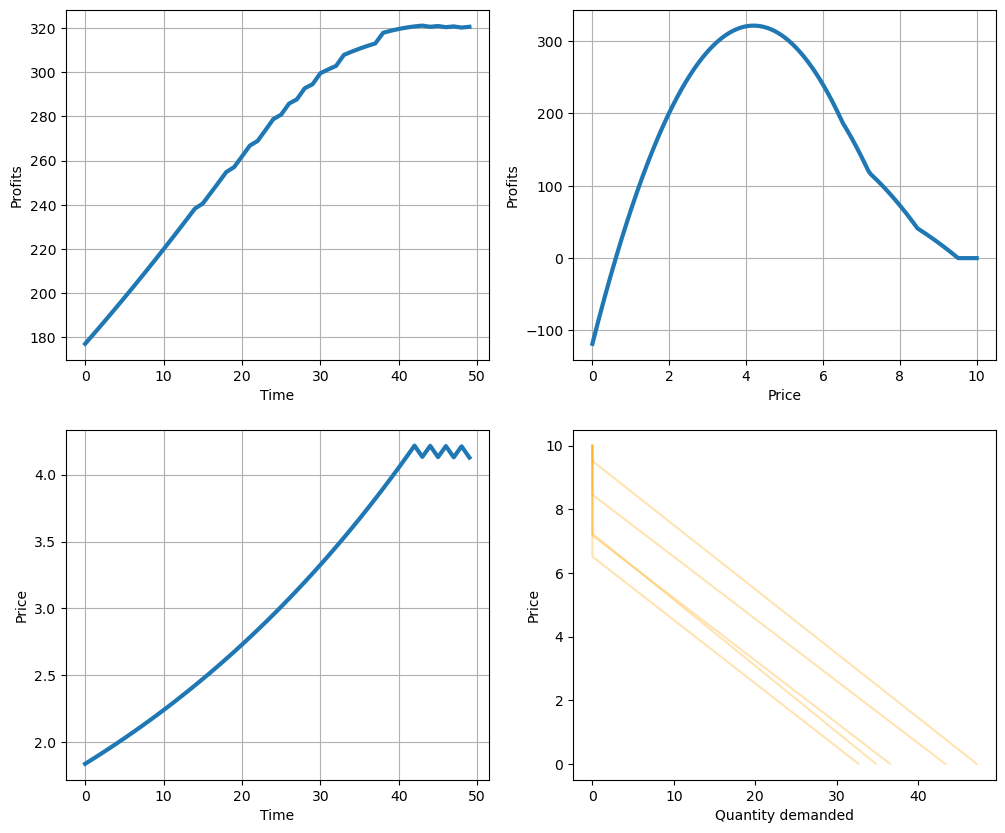

In [66]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=False, sharex=False)

axs[0, 0].plot(all_seller_profits, linewidth=3)
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("Profits")
axs[0, 0].grid(True)

p_values = np.linspace(0, 10, 500)
D = demand(p_values).sum(0)
profit = D * p_values - marginal_cost * D
axs[0, 1].plot(p_values, profit, linewidth=3)
axs[0, 1].set_xlabel("Price")
axs[0, 1].set_ylabel("Profits")
axs[0, 1].grid(True)

axs[1, 0].plot(avg_prices, linewidth=3)
axs[1, 0].set_xlabel("Time")
axs[1, 0].set_ylabel("Price")
axs[1, 0].grid(True)

q_d = demand(p_values)
for i in range(num_buyers):
    axs[1, 1].plot(q_d[i], price_range, color='orange', alpha=0.3, 
             label="Buyer Demand" if i == 0 else "")
axs[1, 1].set_xlabel("Quantity demanded")
axs[1, 1].set_ylabel("Price")
    

In [63]:
(buyer_A/(2*buyer_B) + marginal_cost/2).mean()

4.194327593683385